In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 426kB/s 
     |████████████████████████████████| 2.7MB 27.5MB/s 


In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
# from nltk.tokenize import sent_tokenize
from collections import Counter
import pandas as pd
import re
from konlpy.tag import Okt
import pickle
import matplotlib.pyplot as plt
import numpy as np
okt = Okt()

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [0]:
# 날 저녁 부산 병원 원장 실 환자 명 노크 .  문장에서 명사만 추출하고 .을 남겨두었음.
book_data = pd.read_csv("/content/drive/My Drive/colab/BOOK_DATA/DATA/books_df.csv", index_col=0)

In [0]:
# 10진 분류 라벨 값
label_10 = book_data['점수'].values

In [0]:
book_data.head(5)

,제목,Text,레벨,점수,키워드
0,가난한 사람들을 위한 의사 장기려,['날 저녁 부산 병원 원장 실 환자 명 노크 . 문 사람 병원 입원 창의 농부 ....,초등1,5,"['의사', '연구', '생명', '가난', '사명감', '희생']"
1,간서치 형제의 책 읽는 집,['김 서린 방 형 나이 아우 책상 책 . 소리 책 벽 한기 . 한기 기운 . 이 ...,초등4,5,"['이덕무', '이공무', '독서', '가난', '서자']"
2,강아지로 변한 날,['그 얘기 무슨 얘기 보름달 사람 개 개 사람 누가 앞 순영 정민 강아지 날 중이...,초등1,4,"['습관', '바른말', '고운말', '비속어', '언어']"
3,"강치가 들려주는 우리 땅, 독도 이야기",['제 장강 치 사냥꾼 나카이 독도 강치 살육 바다 새색시 . 바람 점 불지 파도 ...,초등5,8,"['독도', '일본', '역사', '자연', '지리', '보호']"
4,개구쟁이 얼룩이,['민희 개 순돌이 새끼 세 마리 . 강아지 모두 엄마 품 젖 시작 . 민희 식구 ...,유치,2,"['장난', '단점', '사랑', '이해심', '사랑']"


# 10진분류에서 정확도가 잘 나오지 않아 카테고리를 5개로 줄임

In [0]:
label_5 = []
for i in book_data['점수'].values:
    if i < 3:
        label_5.append(1)
    elif i < 5:
        label_5.append(2)
    elif i < 7:
        label_5.append(3)
    elif i < 8:
        label_5.append(4)
    else:
        label_5.append(5)

In [0]:
# 원핫 인코딩
book_data_onehot = pd.get_dummies(book_data, columns=['점수'], prefix='점수') # 원핫 인코딩

In [0]:
onehot_encoding = book_data_onehot.iloc[:,4:] # 라벨값을 변수에 담음

# 텍스트 처리

In [0]:
book_text = book_data['Text'] # 변수이름을 새로 받음

#한국어 불용어사전
stop_words = open("/content/drive/My Drive/colab/BOOK_DATA/DATA/korstopwords.txt",encoding="utf-8")
stop_words = stop_words.readlines()
stop_words = [line.rstrip() for line in stop_words]

In [0]:
# 텍스트의 형태 [단어, 단어, 단어] / 정확도가 더 높은 데이터의 형태
def clean_text_word(data):
    result = okt.nouns(data)
    book_list = []
    for i in result:
        if len(i) > 1 and not i in stop_words:
            book_list.append(i)
    return book_list

In [0]:

# book_text = book_text.apply(lambda x: x.split(".")) # .기준으로 문장을 나눠준다.


# # text의 형태 ("단어 단어 단어, 단어 단어")
# # 학습 결과 학습이 잘 이루어 지지 않음.

# def clean_text(data):
#   result = []
#   for w in data:
#     result.append(okt.nouns(w))
#     book_list = []
#   for s in result:
#     list_full = []
#     for word in s:
#       if len(word) > 1 and not word in stop_words:
#         list_full.append(word)
#     book_list.append(list_full)
#   return book_list

## 단어를 띄어쓰기 기준으로 나누어줌
# def join_sentence(data):
#   result = []
#   for one_list in data:
#     if len(one_list) > 1:
#       result.append(" ".join(one_list))
#   return result

In [10]:
# 단어,단어,단어의 형태 데이터
book_text_wordtoken = book_text.apply(clean_text_word)
book_text_wordtoken.head(5)

0    [저녁, 부산, 병원, 원장, 환자, 노크, 사람, 병원, 입원, 창의, 농부, 모...
1    [서린, 나이, 아우, 책상, 소리, 한기, 한기, 기운, 형제, 스스로, 남산, ...
2    [얘기, 얘기, 보름달, 사람, 사람, 누가, 순영, 정민, 강아지, 중이, 하루,...
3    [장강, 사냥꾼, 나카이, 독도, 강치, 살육, 바다, 새색시, 바람, 불지, 파도...
4    [민희, 순돌이, 새끼, 마리, 강아지, 엄마, 시작, 민희, 식구, 강아지, 이름...
Name: Text, dtype: object

In [0]:
#두번째의 함수를 이용한 전처리 / 정확도가 낮아 사용하지 않음
# book_text_v1 = book_text.apply(clean_text)
# book_text_v1 = book_text_v1.apply(join_sentence)

NameError: ignored

In [0]:
# 텍스트의 길이를 찍어볼 수 있다.
train_length = book_text_wordtoken.apply(len)

#### 시각화

<function matplotlib.pyplot.show>

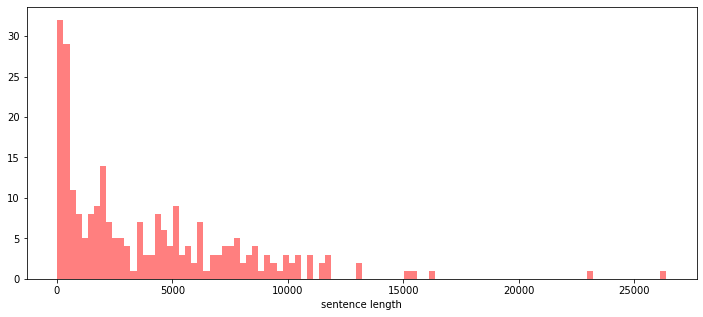

In [0]:
# 전체 책의 문장 길이들을 알 수 있다.
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 100, alpha = 0.5, color = 'r')
plt.xlabel('sentence length')
plt.ylabel('')
plt.show

#### 문장의 길이 분포 확인

In [0]:
print('max length :', np.max(train_length))
print('min length :', np.min(train_length))
print('mean length :', np.mean(train_length))
print('50 % percentile :', np.percentile(train_length, 50))
print('85 % percentile :', np.percentile(train_length, 85))
print('std length :', np.std(train_length))

max length : 26386
min length : 21
mean length : 3963.7312252964425
50 % percentile : 2520.0
85 % percentile : 8032.5999999999985
std length : 4036.726389485722


# 파라미터 설정

In [0]:
num_words = 30000
max_len = 3000 # 문장의 평균길이를 기준으로 수치를 정함.
emb_size = 256

### 정수 인코딩

In [0]:
tok = Tokenizer(num_words = num_words)
tok.fit_on_texts(list(book_text_wordtoken))
X = tok.texts_to_sequences(X)

In [0]:
# 패딩하여 모든 책들의 길이를 맞춤
X = sequence.pad_sequences(X, maxlen = max_len, padding='post')

# 모델링

In [0]:
# 딥러닝 모델
inp = Input(shape=(max_len, )) #maxlen=200 as defined earlier
x = Embedding(num_words, emb_size)(inp)
x = LSTM(65, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(10, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### early stopping

In [0]:
book_data_onehot

,제목,Text,레벨,키워드,점수_1,점수_2,점수_3,점수_4,점수_5,점수_6,점수_7,점수_8,점수_9,점수_10
0,가난한 사람들을 위한 의사 장기려,['날 저녁 부산 병원 원장 실 환자 명 노크 . 문 사람 병원 입원 창의 농부 ....,초등1,"['의사', '연구', '생명', '가난', '사명감', '희생']",0,0,0,0,1,0,0,0,0,0
1,간서치 형제의 책 읽는 집,['김 서린 방 형 나이 아우 책상 책 . 소리 책 벽 한기 . 한기 기운 . 이 ...,초등4,"['이덕무', '이공무', '독서', '가난', '서자']",0,0,0,0,1,0,0,0,0,0
2,강아지로 변한 날,['그 얘기 무슨 얘기 보름달 사람 개 개 사람 누가 앞 순영 정민 강아지 날 중이...,초등1,"['습관', '바른말', '고운말', '비속어', '언어']",0,0,0,1,0,0,0,0,0,0
3,"강치가 들려주는 우리 땅, 독도 이야기",['제 장강 치 사냥꾼 나카이 독도 강치 살육 바다 새색시 . 바람 점 불지 파도 ...,초등5,"['독도', '일본', '역사', '자연', '지리', '보호']",0,0,0,0,0,0,0,1,0,0
4,개구쟁이 얼룩이,['민희 개 순돌이 새끼 세 마리 . 강아지 모두 엄마 품 젖 시작 . 민희 식구 ...,유치,"['장난', '단점', '사랑', '이해심', '사랑']",0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,화수목금토일 친구를 구합니다,드디어 방학이다. 펠릭스는 처음으로 6박 7일 동안 캠프에 가게 되었다. 하지만 벌...,초등3,"['친구', '우정', '고민', '가족', '원수']",0,0,0,0,0,0,1,0,0,0
249,환경 논쟁,"환경 토론,\n\n참공부를 위한 지식과 상상력 놀이\n\n\n\n\n\n환경 문제가...",초등6,"['환경', '지구온난화', '미래에너지', '자연개발']",0,0,0,0,0,0,0,0,1,0
250,황금 깃털,파도가 일렁이기 시작했다. 그 아이가 들어올 준비가 되\n었다는 뜻이다. 보짱은 소...,초등6,"['용기', '후회', '기억', '두려움', '시간', '왕따']",0,0,0,0,0,0,0,0,1,0
251,흐르는 물,1장물속에서물체의무게는어떻게달라질까요?\n간혹 바다에서 음료수 병이 떠다니는 걸 본...,초등4,"['물', '수압', '유수', '얼음', '수증기']",0,0,0,0,0,0,1,0,0,0


In [0]:
# 학습에 진전이 없으면 조기종료를 시킬 수 있게함.
from keras.callbacks import EarlyStopping
file_path = 'save_best'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 30)

In [0]:
batch_size = 16
epochs = 100
model.fit(X,onehot_encoding, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 227 samples, validate on 26 samples
Epoch 1/100





227/227 [==============================] - 92s 403ms/step - loss: 2.2930 - acc: 0.1454 - val_loss: 2.2851 - val_acc: 0.1923
Epoch 2/100
227/227 [==============================] - 87s 384ms/step - loss: 2.1884 - acc: 0.3700 - val_loss: 2.2000 - val_acc: 0.1538
Epoch 3/100
227/227 [==============================] - 86s 381ms/step - loss: 2.0074 - acc: 0.3524 - val_loss: 2.1263 - val_acc: 0.1538
Epoch 4/100
227/227 [==============================] - 87s 383ms/step - loss: 1.8508 - acc: 0.3392 - val_loss: 2.0678 - val_acc: 0.1538
Epoch 5/100


KeyboardInterrupt: ignored

# CountVectorizer / 언어모델

In [0]:
# 단순히 단어의 빈도수만을 가지고 학습을 시킴
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )

In [0]:
def join_text(data):
  result=" ".join(data)
  return result

In [0]:
# cv에 넣기전 데이터의 최종 형태 
un_vector = book_text_wordtoken.apply(join_text)

In [0]:
feature_vector_cv = vectorizer.fit_transform(un_vector)
feature_vector_cv.shape

(253, 2000)

In [0]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['가게', '가격', '가공', '가기', '가까이', '가끔', '가능성', '가도', '가득', '가로']

In [0]:
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)

# for tag, count in zip(vocab, dist):
#     print(count, tag)

pd.DataFrame(dist, columns=vocab)

,가게,가격,가기,가까이,가끔,가능성,가득,가로,가루,가면,...,환경,환자,활동,활짝,황금,황제,회사,회의,효과,흡수
0,439,260,225,432,319,192,385,224,209,493,...,911,251,768,205,308,370,504,231,281,297


In [0]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,가게,가격,가기,가까이,가끔,가능성,가득,가로,가루,가면,...,환경,환자,활동,활짝,황금,황제,회사,회의,효과,흡수
0,0,0,1,0,0,0,0,0,0,0,...,0,29,1,0,0,0,0,0,0,0
1,3,0,0,0,0,0,4,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,1,0,1,5,0,0,0,2,0,2,...,1,1,6,1,9,6,1,5,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF - IDF / 언어모델

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer='char',sublinear_tf=True, ngram_range= (1,3), max_features = 5000)
X = vectorizer.fit_transform(un_vector)

# word2Vec / 언어모델

In [0]:
from gensim.models.word2vec import Word2Vec

book_data_sent = pd.read_csv("/content/drive/My Drive/colab/BOOK_DATA/DATA/books_origin_df.csv", index_col=0)

with open('./Data/crawling_df.pkl', "rb") as f:
    crawling_df = pk.load(f)

crawling_text = crawling_df.Context.values

# 텍스트 처리 part 2  / word2Vec용

In [0]:
def clean_word2Vec(data):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('',data)
    return result

def okt_token(data):
    result = okt.morphs(data)
    return result

In [0]:
# 한글만 남김
word2Vec_data = book_data_sent['Text'].apply(clean_word2Vec)
word2Vec_data = word2Vec_data.apply(okt_token)

In [0]:
#모델 새로 만들기
model = Word2Vec(word2Vec_data, size = 300, window = 7, min_count=30)
model.save("/content/drive/My Drive/colab/BOOK_DATA/DATA/wordvec_sent.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# ML 용

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features, ), dtype="float32")  # pre-initialize (for speed)
    nwords = 0
    index2word_set = model.index2word  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec, model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec


def get_avg_feature_vecs(books, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    books_feature_vecs = np.zeros((len(books), num_features), dtype='float32')  # pre-initialize (for speed)
    
    for i in range(len(books)):
        books_feature_vecs[counter] = make_feature_vec(books[i], model, num_features)
        counter = counter + 1
    
    return books_feature_vecs

In [0]:
# from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

wordvec_model = Word2Vec.load("/content/drive/My Drive/colab/BOOK_DATA/DATA/wordvec_sent.model")

books = word2Vec_data.values

X_wordvecML = get_avg_feature_vecs(books, wordvec_model.wv, 300)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Train 데이터와 Test 데이터로 구분하자( wrod2Vec )

In [0]:
X_word_train, X_word_valid, y_word_train, y_word_valid = train_test_split(X_wordvecML, label_10, test_size = 0.1, shuffle = True, random_state = 2019)

# Train and Test DATA

In [0]:
# cv의 train, test split code, 혹은 tf-idf(변수이름을 변경하여 사용함.)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_vector_cv, label_5, test_size=0.1, random_state=42)

# 랜덤 포레스트


In [0]:
# 기본적인 랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest = RandomForestClassifier(
    n_estimators = 500, n_jobs = -1, random_state=2018)
# forest.fit(X_train,y_train)

In [0]:
prediction = forest.predict(X_valid)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [0]:
print('Accuracy =', accuracy_score(y_valid, prediction))

Accuracy = 0.6274509803921569


In [0]:
def randomforest(data,label):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    scoring = 'accuracy'
    score = cross_val_score(forest, feature_vector_cv, y_1, cv=k_fold, n_jobs=-1, scoring=scoring)
    return round(np.mean(score)*100,2)

In [0]:
randomforest(X_train,y_train)

69.95

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, feature_vector_cv, y_1, cv=k_fold, n_jobs=-1, scoring=scoring)
score

NameError: ignored

In [0]:
round(np.mean(score)*100,2)

69.95

In [0]:
print('Accuracy =', accuracy_score(y_valid, prediction))

Accuracy = 0.6274509803921569


# Decision Tree

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

In [0]:
# 단하나의 Decision Tree를 사용할경우
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_word_train, y_word_train)
y_pred_tree = tree_clf.predict(X_word_valid)
print('Accuracy =', accuracy_score(y_word_valid, y_pred_tree))

Accuracy = 0.11538461538461539


In [0]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.46153846153846156


# 앙상블

# hard voting

In [0]:
# import warnings
# warnings.filterwarnings('ignore')

In [0]:
ext_clf = ExtraTreesClassifier(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

In [0]:
# log_clf = LogisticRegression(random_state=42)
# rnd_clf = RandomForestClassifier(random_state=42)
# svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('et', ext_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_wordvecML_train, y_wordvecML_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
               

In [0]:
from sklearn.metrics import accuracy_score

for clf in (ext_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_wordvecML_train, y_wordvecML_train)
    y_pred = clf.predict(X_wordvecML_valid)
    print(clf.__class__.__name__, accuracy_score(y_worvecML_valid, y_pred))

ExtraTreesClassifier 0.07692307692307693
RandomForestClassifier 0.23076923076923078


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.07692307692307693
VotingClassifier 0.038461538461538464


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# soft voting

In [0]:
# log_clf = LogisticRegression(random_state=42)
# rnd_clf = RandomForestClassifier(random_state=42)
# svm_clf = SVC(probability=True, random_state=42)
ext_clf = ExtraTreesClassifier(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('et', ext_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
               

In [0]:
for clf in (ext_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_word_train, y_word_train)
    y_pred = clf.predict(X_word_valid)
    print(clf.__class__.__name__, accuracy_score(y_word_valid, y_pred))

ExtraTreesClassifier 0.2692307692307692
RandomForestClassifier 0.3076923076923077


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.07692307692307693
VotingClassifier 0.2692307692307692


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 에이다 부스트

In [0]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_valid)
print('Accuracy =', accuracy_score(y_valid, y_pred))

Accuracy = 0.37254901960784315


# XG boost

In [0]:
from xgboost import XGBClassifier
xg = XGBClassifier()

In [0]:
gbm = XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 500,
 max_depth= 4,
 min_child_weight= 2,
 gamma=1,
#  gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train)
predictions = gbm.predict(X_test)

In [0]:
print('Accuracy =', accuracy_score(y_test, predictions))

Accuracy = 0.5769230769230769


In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
xg_param_grid = {"learning_rate": [0.02,0.1],
              "n_estimators": [100, 500],
              "max_depth": [2, 4],
              "min_child_weight": [1, 2],
              "gamma":[0,1],
              "subsample": [0,1],
              "colsample_bytree" :[0, 1],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(xg, param_distributions=xg_param_grid,
                                   n_iter=100, cv=KFold(n_splits=5), iid=False, verbose = 1)

# start = time()
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 28.8min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           object...
                                           verbosity=1),
                   iid=False, n_iter=100, n_jobs=None,
                   param_distributions={'colsample_bytree': [0, 1],
                                        'criterion': ['gini', 'ent

# 그리드 서치

### Dicision Tree 그리드서치
### 랜덤 서치도 사용해보려했으나 할애할 시간이 부족했음.

In [0]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [0]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:   28.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
prediction = gsadaDTC.predict(X_test)
print('Accuracy =', accuracy_score(y_test, prediction))

Accuracy = 0.6538461538461539


In [0]:
gsadaDTC.best_score_

0.36123348017621143

In [0]:
# 랜덤포레스트보다 더 무작위하게 특성을 나눔
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False],
                "n_estimators" : [100,300],
                "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
prediction = gsExtC.predict(X_test)
print('Accuracy =', accuracy_score(y_test, prediction))

Accuracy = 0.5769230769230769


In [0]:
gsExtC.best_score_

0.6431718061674009

In [0]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6431718061674009

In [0]:
print("테스트 세트 정확도: {:.3f}".format(gsRFC.score(X_test, y_test)))

테스트 세트 정확도: 0.538


In [0]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                'n_estimators' : [100, 200, 300],
                'learning_rate' : [0.1, 0.05, 0.01],
                'max_depth': [4,8],
                'min_samples_leaf': [100,150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs=4, verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed: 10.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
prediction = gsGBC.predict(X_wordvecML_valid)

print('Accuracy =', accuracy_score(y_worvecML_valid, prediction))
# print("테스트 세트 정확도: {:.3f}".format(gsGBC.score(X_test, y_test)))

Accuracy = 0.19230769230769232


In [0]:
gsGBC.best_score_

0.18502202643171806

In [0]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs = 4, verbose = 1)

gsSVMC.fit(X_train, y_train)

SVMC_best = gsSVMC.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:  1.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
print("테스트 세트 정확도: {:.3f}".format(gsSVMC.score(X_test, y_test)))

테스트 세트 정확도: 0.385


In [0]:
gsSVMC.best_score_

0.41106719367588934

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import learning_curve

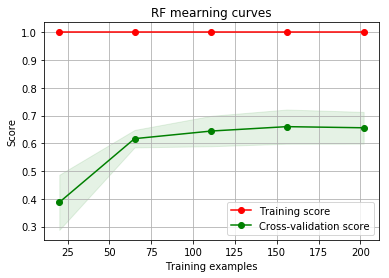

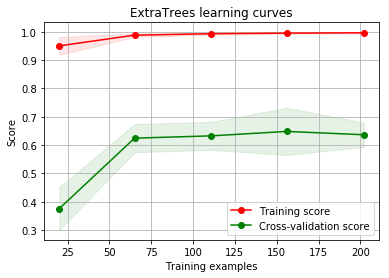

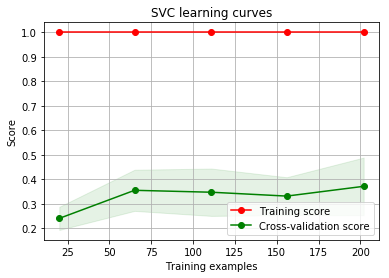

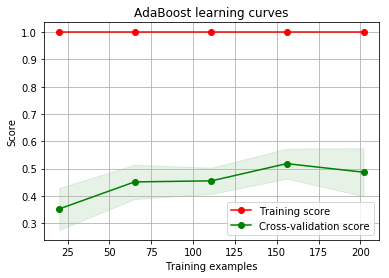

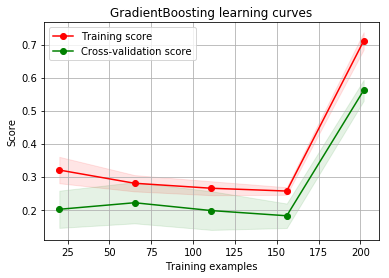

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",feature_vector_cv,y_1,cv=KFold(n_splits=5))
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",feature_vector_cv,y_1,cv=KFold(n_splits=5))
# g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",feature_vector_cv,y_1,cv=KFold(n_splits=5))
# g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",feature_vector_cv,y_1,cv=KFold(n_splits=5))
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",feature_vector_cv,y_1,cv=KFold(n_splits=5))